Best objective: 80 (0.08)
Objective bound: 84
Minimum objective: 80
Cache sizes - Greedy: 2554, Lickety: 4788, Trie: 0, Trie cache: OFF
Minimum objective: 80
Rashomon set size: 33
Histogram entries: [(80, 12), (81, 8), (82, 5), (84, 8)]
Objective = 80, Count = 12
Objective = 81, Count = 8
Objective = 82, Count = 5
Objective = 84, Count = 8

Total Rashomon trees: 33

Tree 0
Objective (raw):      80
Objective (normalized): 0.080000

Predictions from tree 0 (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]

Tree 0 has 8 leaves.
All root-to-leaf paths:
[+2, +3, +14] -> 0
[+2, +3, -14] -> 1
[+2, -3, +14] -> 1
[+2, -3, -14] -> 0
[-2, +3, +14] -> 1
[-2, +3, -14] -> 0
[-2, -3, +14] -> 0
[-2, -3, -14] -> 1


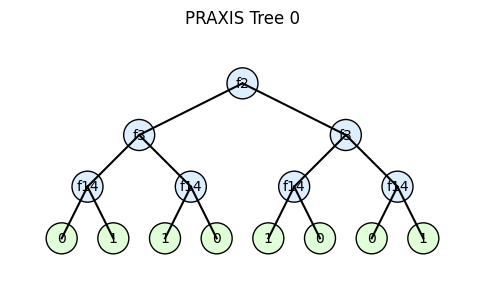

<Figure size 640x480 with 0 Axes>

Tree 32
Objective (raw):      84
Objective (normalized): 0.084000

Predictions from tree 32 (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]

Tree 32 has 8 leaves.
All root-to-leaf paths:
[+14, +3, +12] -> 0
[+14, +3, -12] -> 1
[+14, -3, +2] -> 1
[+14, -3, -2] -> 0
[-14, +3, +2] -> 1
[-14, +3, -2] -> 0
[-14, -3, +2] -> 0
[-14, -3, -2] -> 1


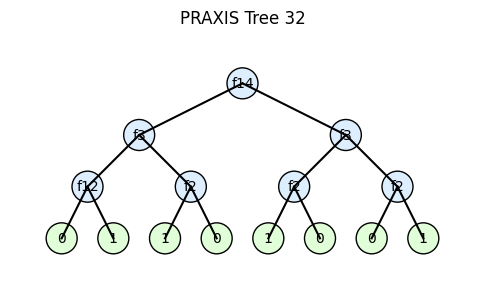

<Figure size 640x480 with 0 Axes>


[Dimensionality] Number of trees in all_preds_list: 33
[Dimensionality] Shape of first tree's prediction vector: (1000,)

[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples): (33, 1000)
Majority-vote predictions (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]


In [1]:
import numpy as np
from praxis import PRAXIS
import matplotlib.pyplot as plt

n_samples = 1000
n_features = 10

rng = np.random.default_rng(0)

X = (rng.random((n_samples, n_features)) > 0.5).astype(np.uint8)

# label: odd/even parity of first 4 features
three_sum = X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3]
y = (three_sum % 2).astype(int)

# extra feature for interest: 1 if x1 + x2 is even, 0 otherwise
sum_01 = X[:, 0] + X[:, 1]
even_01 = ((sum_01 % 2) == 0).astype(np.uint8)

# make 4 noisy copies of the first 4 columns
# each entry is flipped with probability 1/100
base_four = X[:, :4].copy()
flip_mask = (rng.random((n_samples, 4)) < 0.01).astype(np.uint8)  # 1 with prob 0.01, else 0
noisy_four = base_four ^ flip_mask  # XOR to flip bits where flip_mask == 1

# append these extra features
X = np.hstack([X, noisy_four, even_01[:, None]])


model = PRAXIS()

model.fit(
    X, y,
    lambda_reg=0.01,        # sparsity penalty - recommended
    depth_budget=5,         # max tree depth as defined by number of splits along any path
    rashomon_mult=0.05,     # rashomon bound: 5% worse than initial oracle objective
    # optional parameters (default is sufficient)
    multiplicative_slack=0, # extra slack factor 
    key_mode="hash",        # "hash" for memory savings at an astronomically low change of error or "exact"
    trie_cache_enabled=False, # not recommended with hash
    lookahead_k=1, # 1 = LicketySPLIT oracle, 0 = greedy, >1 higher-tiered oracles
)

print("Minimum objective:", model.get_min_objective())
print("Rashomon set size:", model.count_trees())

hist = model.get_root_histogram()
print("Histogram entries:", hist)

for obj, cnt in hist:
    print(f"Objective = {obj}, Count = {cnt}")

# we will inspect the first and last trees
num_trees = model.count_trees()
tree_indices = [0, num_trees - 1]

print(f"\nTotal Rashomon trees: {num_trees}\n")

for tree_idx in tree_indices:
    print("=" * 60)
    print(f"Tree {tree_idx}")
    
    obj_raw, obj_norm = model.get_tree_objective(tree_idx)
    print(f"Objective (raw):      {obj_raw}")
    print(f"Objective (normalized): {obj_norm:.6f}")

    preds_i = model.get_predictions(tree_idx, X)
    print(f"\nPredictions from tree {tree_idx} (first 10 samples):")
    print(preds_i[:10])

    paths_str, preds = model.get_tree_paths_str(tree_idx)
    print(f"\nTree {tree_idx} has {len(paths_str)} leaves.")

    print("All root-to-leaf paths:")
    for s, p in zip(paths_str, preds):
        print(s, "->", p)

    fig, ax = plt.subplots(figsize=(6, 4))
    model.plot_tree(tree_idx, ax=ax)
    ax.set_title(f"PRAXIS Tree {tree_idx}")
    plt.tight_layout()
    plt.show()
    
# list-of-vectors version
all_preds_list = model.get_all_predictions(X, stack=False)
print(f"\n[Dimensionality] Number of trees in all_preds_list: {len(all_preds_list)}")
if len(all_preds_list) > 0:
    print("[Dimensionality] Shape of first tree's prediction vector:",
          all_preds_list[0].shape)

# stacked matrix version
all_preds_mat = model.get_all_predictions(X, stack=True)
print("\n[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples):",
      all_preds_mat.shape)

majority_vote = (all_preds_mat.mean(axis=0) >= 0.5).astype(np.uint8)
print("Majority-vote predictions (first 10 samples):")
print(majority_vote[:10])


Minimum objective:Best objective: 600 (0.06)
Objective bound: 630
Minimum objective: 600
Cache sizes - Greedy: 0, Lickety: 77901, Trie: 0, Trie cache: OFF
 600
Rashomon set size: 4464
Histogram entries: [(600, 360), (610, 128), (611, 52), (612, 256), (613, 128), (614, 564), (615, 52), (616, 156), (618, 104), (621, 16), (622, 188), (623, 72), (624, 448), (625, 198), (626, 618), (627, 238), (628, 382), (629, 236), (630, 268)]
Objective = 600, Count = 360
Objective = 610, Count = 128
Objective = 611, Count = 52
Objective = 612, Count = 256
Objective = 613, Count = 128
Objective = 614, Count = 564
Objective = 615, Count = 52
Objective = 616, Count = 156
Objective = 618, Count = 104
Objective = 621, Count = 16
Objective = 622, Count = 188
Objective = 623, Count = 72
Objective = 624, Count = 448
Objective = 625, Count = 198
Objective = 626, Count = 618
Objective = 627, Count = 238
Objective = 628, Count = 382
Objective = 629, Count = 236
Objective = 630, Count = 268

Total Rashomon trees: 44

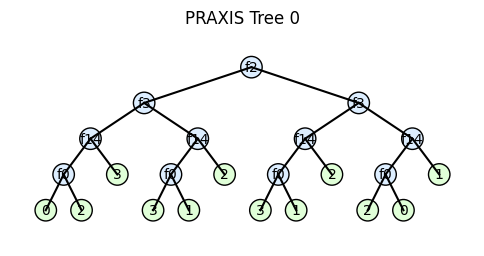

<Figure size 640x480 with 0 Axes>

Tree 4463
Objective (raw):      630
Objective (normalized): 0.063000

Predictions from tree 4463 (first 10 samples):
[1 2 2 2 2 2 1 3 3 3]

Tree 4463 has 12 leaves.
All root-to-leaf paths:
[+14, +3, +1, +2] -> 0
[+14, +3, +1, -2] -> 3
[+14, +3, -1, +12] -> 2
[+14, +3, -1, -12] -> 1
[+14, -3, +2, +1] -> 3
[+14, -3, +2, -1] -> 1
[+14, -3, -2, +11] -> 2
[+14, -3, -2, -11] -> 0
[-14, +3, +2] -> 3
[-14, +3, -2] -> 2
[-14, -3, +2] -> 2
[-14, -3, -2] -> 1


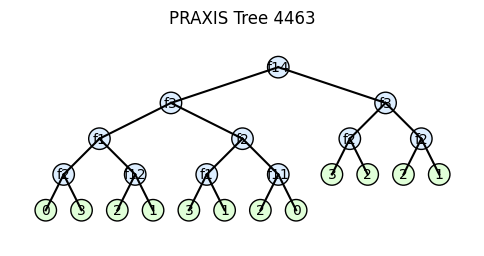

<Figure size 640x480 with 0 Axes>


[Dimensionality] Number of trees in all_preds_list: 4464
[Dimensionality] Shape of first tree's prediction vector: (10000,)

[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples): (4464, 10000)
Majority-vote predictions (first 10 samples):
[1 2 2 2 2 2 1 3 3 3]


In [7]:
import numpy as np
from praxis import PRAXIS
import matplotlib.pyplot as plt

n_samples = 10000
n_features = 10

rng = np.random.default_rng(0)

X = (rng.random((n_samples, n_features)) > 0.5).astype(np.uint8)

# label: 4-parity of first 4 features
three_sum = X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3]
y = (three_sum % 4).astype(int)

# extra feature for interest: 1 if x1 + x2 is even, 0 otherwise
sum_01 = X[:, 0] + X[:, 1]
even_01 = ((sum_01 % 2) == 0).astype(np.uint8)

# make 4 noisy copies of the first 4 columns
# each entry is flipped with probability 1/100
base_four = X[:, :4].copy()
flip_mask = (rng.random((n_samples, 4)) < 0.01).astype(np.uint8)  # 1 with prob 0.01, else 0
noisy_four = base_four ^ flip_mask  # XOR to flip bits where flip_mask == 1

# append these extra features
X = np.hstack([X, noisy_four, even_01[:, None]])


model = PRAXIS()

model.fit(
    X, y,
    lambda_reg=0.005,        # sparsity penalty - recommended
    depth_budget=6,         # max tree depth as defined by number of splits along any path
    rashomon_mult=0.05,     # rashomon bound: 5% worse than initial oracle objective
    # optional parameters (default is sufficient)
    multiplicative_slack=0, # extra slack factor 
    key_mode="hash",        # "hash" for memory savings at an astronomically low change of error or "exact"
    trie_cache_enabled=False, # not recommended with hash
    lookahead_k=5, # 1 = LicketySPLIT oracle, 0 = greedy, >1 higher-tiered oracles
)

print("Minimum objective:", model.get_min_objective())
print("Rashomon set size:", model.count_trees())

hist = model.get_root_histogram()
print("Histogram entries:", hist)

for obj, cnt in hist:
    print(f"Objective = {obj}, Count = {cnt}")

# we will inspect the first and last trees
num_trees = model.count_trees()
tree_indices = [0, num_trees - 1]

print(f"\nTotal Rashomon trees: {num_trees}\n")

for tree_idx in tree_indices:
    print("=" * 60)
    print(f"Tree {tree_idx}")
    
    obj_raw, obj_norm = model.get_tree_objective(tree_idx)
    print(f"Objective (raw):      {obj_raw}")
    print(f"Objective (normalized): {obj_norm:.6f}")

    preds_i = model.get_predictions(tree_idx, X)
    print(f"\nPredictions from tree {tree_idx} (first 10 samples):")
    print(preds_i[:10])

    paths_str, preds = model.get_tree_paths_str(tree_idx)
    print(f"\nTree {tree_idx} has {len(paths_str)} leaves.")

    print("All root-to-leaf paths:")
    for s, p in zip(paths_str, preds):
        print(s, "->", p)

    fig, ax = plt.subplots(figsize=(6, 4))
    model.plot_tree(tree_idx, ax=ax)
    ax.set_title(f"PRAXIS Tree {tree_idx}")
    plt.tight_layout()
    plt.show()
    
# list-of-vectors version
all_preds_list = model.get_all_predictions(X, stack=False)
print(f"\n[Dimensionality] Number of trees in all_preds_list: {len(all_preds_list)}")
if len(all_preds_list) > 0:
    print("[Dimensionality] Shape of first tree's prediction vector:",
          all_preds_list[0].shape)

# stacked matrix version
all_preds_mat = model.get_all_predictions(X, stack=True)
print("\n[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples):",
      all_preds_mat.shape)

majority_vote = all_preds_mat.mean(axis=0).round().astype(np.uint8)
print("Majority-vote predictions (first 10 samples):")
print(majority_vote[:10])


Best objective: 120 (
RID mean_sub_mr (per feature):
feature  0: 0.081962
feature  1: 0.082041
feature  2: 0.482874
feature  3: 0.440909
feature  4: 0.000000
feature  5: 0.000000
feature  6: 0.000000
feature  7: 0.000000
feature  8: 0.000000
feature  9: 0.000000
feature 10: 0.045647
feature 11: 0.040463
feature 12: 0.013635
feature 13: 0.058602
feature 14: 0.495889
0.12)
Objective bound: 121
Minimum objective: 120
Cache sizes - Greedy: 2022, Lickety: 3160, Trie: 0, Trie cache: OFF
Finished RID bootstrap: 1 / 20 with 6047 trees
Best objective: 120 (0.12)
Objective bound: 121
Minimum objective: 120
Cache sizes - Greedy: 1994, Lickety: 3202, Trie: 0, Trie cache: OFF
Finished RID bootstrap: 2 / 20 with 7314 trees
Best objective: 120 (0.12)
Objective bound: 121
Minimum objective: 120
Cache sizes - Greedy: 2033, Lickety: 3276, Trie: 0, Trie cache: OFF
Finished RID bootstrap: 3 / 20 with 4157 trees
Best objective: 120 (0.12)
Objective bound: 121
Minimum objective: 120
Cache sizes - Greedy: 20

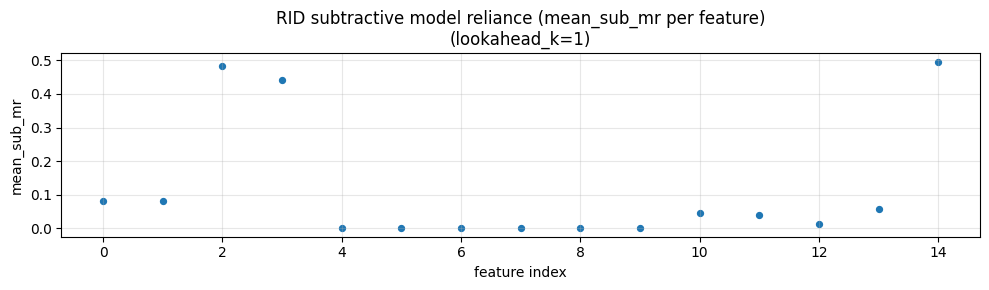

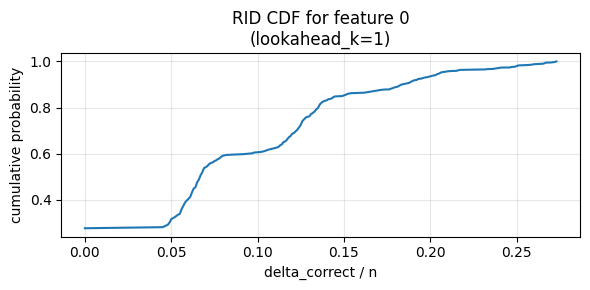

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from praxis import PRAXIS
from praxis import RashomonImportanceDistribution


n_samples = 1000
n_features = 10

rng = np.random.default_rng(0)

X = (rng.random((n_samples, n_features)) > 0.5).astype(np.uint8)

# label: 4-parity of first 4 features
three_sum = X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3]
y = (three_sum % 4).astype(int)

# extra feature for interest: 1 if x1 + x2 is even, 0 otherwise
sum_01 = X[:, 0] + X[:, 1]
even_01 = ((sum_01 % 2) == 0).astype(np.uint8)

# make 4 noisy copies of the first 4 columns
# each entry is flipped with probability 1/100
base_four = X[:, :4].copy()
flip_mask = (rng.random((n_samples, 4)) < 0.01).astype(np.uint8)  # 1 with prob 0.01, else 0
noisy_four = base_four ^ flip_mask  # XOR to flip bits where flip_mask == 1

# append these extra features
X = np.hstack([X, noisy_four, even_01[:, None]])

rid_out = RashomonImportanceDistribution(
    X,
    y,
    lambda_reg=0.01,
    depth_budget=5,
    lookahead_k=1,
    rashomon_mult=0.01,
    binning_map=None,
    seed=0,
    n_boot=20,
)

mean = np.asarray(rid_out["mean_sub_mr"], dtype=float)
cdf_x = rid_out["cdf_x"]
cdf_p = rid_out["cdf_p"]

print("\nRID mean_sub_mr (per feature):")
for j, m in enumerate(mean):
    print(f"feature {j:2d}: {m:.6f}")


# --- Plots ---
# 1) mean importance per feature
x = np.arange(mean.size)

plt.figure(figsize=(10, 3))
plt.scatter(x, mean, s=18)
plt.title("RID subtractive model reliance (mean_sub_mr per feature)\n(lookahead_k=1)")
plt.xlabel("feature index")
plt.ylabel("mean_sub_mr")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) CDF for one feature (pick feature 0 as a simple example)
j = 0
plt.figure(figsize=(6, 3))
plt.plot(cdf_x[j], cdf_p[j])
plt.title(f"RID CDF for feature {j}\n(lookahead_k=1)")
plt.xlabel("delta_correct / n")
plt.ylabel("cumulative probability")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd, numpy as np
from praxis import ThresholdGuessBinarizer

df = pd.read_csv("compas_binarized.csv")
X = df.iloc[:, :-1].to_numpy(np.float32); y = df.iloc[:, -1].to_numpy()
rng = np.random.default_rng(0); m, k = X.shape[1], 200
A = np.zeros((m, k), np.float32); A[rng.integers(0, m, k), np.arange(k)] = 1; A[rng.integers(0, m, k), np.arange(k)] += 1
Z = (X @ A + 0.01 * rng.standard_normal((X.shape[0], k))).astype(np.float32)

enc = ThresholdGuessBinarizer(n_estimators=200, max_depth=2, random_state=0, column_elimination=True)
Zb = enc.fit_transform(Z, y)
print("Z:", Z.shape, "-> Zb:", Zb.shape, "kept:", enc.n_features_out_)


Z: (4966, 200) -> Zb: (4966, 395) kept: 395
